# Gaussian Naive Bayes

A **Gaussian** curve takes the form $f(x) = \frac1{\sigma\sqrt{2\pi}} \exp{\left[-\frac12 \left( \frac{x-\mu}{\sigma} \right)^2\right]}$, **naive** comes from the assumptions made, and **Bayes** from the Bayesian statistics of conditional probability.

## Assumptions of a Naive Bayes
- Features are **conditionally independent** given the class; $$P(X|y=k) = \prod_i P(x_i|y=k)$$
- Continuous features follow a Gaussian distribution; each $$P(x_i|y=k)=\frac1{\sigma_{k,i}\sqrt{2\pi}} \exp{\left[-\frac12 \left( \frac{x_i-\mu_{k,i}}{\sigma_{k,i}} \right)^2\right]}$$

---
## Bayes' Theorem

Given some class $y$, $P(y=k|X) = \frac{P(y=k)\cdot P(X|y=k)}{P(X)}$. We are looking at computing two probabilities (one for each label) and siding with the larger one. This means that we don't care about the denominator here, in both cases we are dividing by the same $P(X)$. Here, we mention the first assumption of a Naive Bayes, which allows us to rewrite the formula:

$$
P(y=k|X) \propto P(y=k)\cdot \prod_{j=1}^d P(x_j|y=k)
$$

And we model each $P(x_j|y=k)$ over a Gaussian/normal distribution (the second assumption):

$$
P(x_j|y=k) \sim \mathcal{N}(x_j; \mu_{k, j}, \sigma_{k, j})
$$

Where:
- $\mu_{k, j}=\frac1{n_k}\cdot \sum_{i:y=k} x_{i, j}$, the mean of feature $j$ within all instances of class $k$.
- $\sigma_{k, j}^2 = \frac1{n_k}\cdot \sum_{i:y=k} [x_{i, j}-\mu_{k, j}]$
- $P(y=k) = \frac{n_k}n$

---
## Underflow

Multiplying many small probabilities can cause numerical issues because the product becomes extremely close to zero, leading to floating-point underflow. To avoid this, we apply the logarithm to probabilities, converting multiplication into addition, which is more stable for computation.

$$
\longrightarrow  \log {P(y=k | X)} \propto \log P(y=k) + \sum_{j=1}^d \log P(x_j | y=k)
$$

We are trying to find the class $k$ to maximise the log-probabilities, so we are only interested in the final term of the above expression.

$$
\Longrightarrow log \left(\mathcal{N}(x_j; \mu_{k, j}, \sigma_{k, j})\right) = \log \left(\frac1{\sigma_{k,i}\sqrt{2\pi}} \exp{\left[-\frac12 \left( \frac{x_i-\mu_{k,i}}{\sigma_{k,i}} \right)^2\right]}\right) = -\frac12 \log(2\pi\sigma_{k,j}) - \frac{(x_j - \mu_{k,j})^2}{2\sigma_{k,j}^2} + prior
$$

Since we only care about the class which has the highest probability, we define our prediction rule as:

$$
\hat{y} = \arg\max_k \left[ \log P(y = k) + \sum_{j=1}^{d} \log \mathcal{N}(x_j; \mu_{k,j}, \sigma_{k,j}) \right]
$$

This selects the class $k$ with the highest total log-probability for $X$.

---
## Recap

1. We have continuous data, which we want to figure out the correct class $k$ to label such data by.
2. We will fit the Naive Bayes by finding the mean and variance for each value, we calculate the prior probability for each class. 
3. Then, we use the normal distribution to estimate the probabilities using the more stable logarithmic method derived above.

---
# Implementation

In [9]:
# build with numpy
import numpy as np

# implement as a class (OOP)
class GaussianNB:
    
    def fit(self, X, y):
        X, y = np.asarray(X), np.asarray(y) # ensure we have numpy arrays
        self.classes_ = np.unique(y) # what classes we have

        # useful constants for the input data, so we can get means/vars/probs
        n_classes, n_features = len(self.classes_), X.shape[1]

        # initialise variables outside of loop
        self.means_ = np.zeros((n_classes, n_features))
        self.variances_ = np.zeros((n_classes, n_features))
        self.priors_ = np.zeros(n_classes)

        for idx, k in enumerate(self.classes_):
            X_k = X[y == k] # our class array

            # finding params
            self.means_[idx] = X_k.mean(axis=0)
            self.variances_[idx] = X_k.var(axis=0)
            self.priors_[idx] = X_k.shape[0] / X.shape[0]

        # model is fitted, can return the instance
        return self
    
    def _log_gaussian(self, X):
        num = -0.5 * (X[:, None, :] - self.means_)**2 / self.variances_
        log_prob = num - 0.5 * np.log(2 * np.pi * self.variances_)
        return log_prob.sum(axis=2)
    
    def predict(self, X):
        X = np.asarray(X)

        log_L = self._log_gaussian(X)
        log_prior = np.log(self.priors_)

        return self.classes_[np.argmax(log_L + log_prior, axis=1)]

---

## Dataset

Import the wine dataset from sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html.

There are three wine classes, 173 samples total and 13 features.

In [18]:
# wine data
from sklearn.datasets import load_wine

# load some preprocessing and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# random state seed for this implementation...
# ...
# drumroll
# ...
# The Hardy-Ramanujan number
random_state = 1729
# The smallest number which can be expressed as the sum of two different cubes in two different ways
# See "mystery.txt" for the story

# load + preprocess
X, y = load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=0.2)

model = GaussianNB().fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Testing Accuracy:", accuracy_score(y_pred, y_test))

Testing Accuracy: 0.9444444444444444


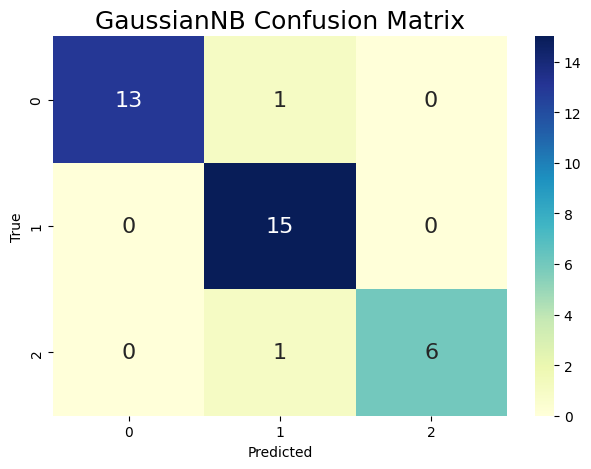

In [19]:
# plotting a conf-matrix
import seaborn as sns
import matplotlib.pyplot as plt

# plot the conf-matrix
sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, cmap="YlGnBu", annot_kws={"fontsize": 16})
plt.title("GaussianNB Confusion Matrix", fontsize=18)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()